<center>
<div style="color:;
           display:fill;
           border-radius:5px;
           background-color: lightgray;
           font-size:110%;
           letter-spacing:0.5px">

<h2 style="padding: 10px;
              color:white;">Dog breed identification
</h2>
</div>

1. [Introduction](#introduction)
1. [Data Collection](#datacollection)
1. [Data Analysis](#dataanalysis)
    1. [Explore Labels](#explorelabels)
    1. [Explore Images](#exploreimages)
    1. [Data Visualization](#datavisualization)
1. [Data Preprocessing](#datapreprocessing)
    1. [Data Augmentation](#dpdataaugmentation)
    1. [Labels encoding](#labelsencoding)
    1. [Create Dataset](#createdataset)
1. [Model Training and Evaluation](#trainandevaluate)
    1. [Search best models](#searchbestmodels)
    1. [Stacking classifier](#stackingclassifier)
1. [Submission](#submission)
1. [Conclusion](#conclusion)

# Introduction <a class="anchor" id="introduction"></a>

In this notebook, for the task of dog breed identification, I will try to evaluate different prelearned models from <a href="https://keras.io/api/applications/">Keras Applications</a> and <a href="https://pypi.org/project/vit-keras/">Keras implementation of ViT (Vision Transformer)</a>, and then build a stacking classifier from the best of them. It is also interesting to check how well models based on CNNs perform compared to Vision Transformer.

Vision Transformer is a very interesting architecture for image classification that uses a Transformer-like architecture over patches of the image. I will not cover this architecture in my notebook (there are a lot of resources in web described this topic), I will only check its performance for this classification task.

In [36]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=(RuntimeWarning, FutureWarning, UserWarning))

import time
import os
import numpy as np
import pandas as pd
import math
import gc
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import itertools
from itertools import islice
import tensorflow as tf
import keras_tuner as kt
import keras
from keras import layers, Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, concatenate, Concatenate, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.losses import categorical_crossentropy, SparseCategoricalCrossentropy
from keras.metrics import categorical_accuracy
from keras.applications import Xception, InceptionResNetV2, MobileNetV2, DenseNet201, ResNet50, EfficientNetB4, EfficientNetB5
from IPython.display import Markdown, display
from sklearn.preprocessing import LabelEncoder
from vit_keras import vit

# Disable LayoutOptimizer to avoid INVALID_ARGUMENT errors
os.environ['TF_DISABLE_MKL'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_ENABLE_LAYOUT_OPTIMIZER'] = '0'

# to make this notebook's output stable across runs
np.random.seed(23200383)
tf.random.set_seed(23200383)

IMAGE_SIZE = (448, 448)
BATCH_SIZE = 32

AttributeError: module 'inspect' has no attribute 'ArgSpec'

In [3]:
# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")
tf.config.list_physical_devices("GPU")

GPU available (YESS!!!!)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Collection <a class="anchor" id="datacollection"></a>

In [69]:
labels_path = f"/kaggle/input/dog-breed-identification/labels.csv"
submission_path = f"/kaggle/input/dog-breed-identification/sample_submission.csv"

labels_df = pd.read_csv(labels_path)
submission_df = pd.read_csv(submission_path)

In [5]:
train_folder =aggregate f"/kaggle/input/dog-breed-identification/train/"
test_folder = f"/kaggle/input/dog-breed-identification/test/"
train_folder, test_folder

('/kaggle/input/dog-breed-identification/train/',
 '/kaggle/input/dog-breed-identification/test/')

# Data Analysis <a class="anchor" id="dataanalysis"></a>

## Explore Labels <a class="anchor" id="explorelabels"></a>

In [6]:
#describe
labels_df.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126

In [7]:
import seaborn as sns
#function to show bar length
def barw(ax): 
    
    for p in ax.patches:
        val = p.get_width() #height of the bar
        x = p.get_x()+ p.get_width() # x- position 
        y = p.get_y() + p.get_height()/2 #y-position
        ax.annotate(round(val,2),(x,y))
        
#finding top dog brands

plt.figure(figsize = (15,30))
ax0 =sns.countplot(y=labels_df['breed'],order=labels_df['breed'].value_counts().index)
barw(ax0)
plt.show()

In [8]:
print(f'Labels shape:\t {labels_df.shape}',
     f'\nSubmission shape:\t {submission_df.shape}')

Labels shape:	 (10222, 2) 
Submission shape:	 (10357, 121)


In [9]:
# #total unique breeds

labels_df['breed'].nunique()

120

In [10]:
labels_df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [11]:
submission_df.head()

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e       0.008333      0.008333   
1  00102ee9d8eb90812350685311fe5890       0.008333      0.008333   
2  0012a730dfa437f5f3613fb75efcd4ce       0.008333      0.008333   
3  001510bc8570bbeee98c8d80c8a95ec1       0.008333      0.008333   
4  001a5f3114548acdefa3d4da05474c2e       0.008333      0.008333   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0             0.008333  0.008333                        0.008333     0.008333   
1             0.008333  0.008333                        0.008333     0.008333   
2             0.008333  0.008333                        0.008333     0.008333   
3             0.008333  0.008333                        0.008333     0.008333   
4             0.008333  0.008333                        0.008333     0.008333   

   australian_terrier   basenji    basset  ...  toy_poodle  toy_terrier  \
0            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
1            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
2            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
3            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
4            0.008333  0.008333  0.008333  ...    0.008333     0.008333   

     vizsla  walker_hound  weimaraner  welsh_springer_spaniel  \
0  0.008333      0.008333    0.008333                0.008333   
1  0.008333      0.008333    0.008333                0.008333   
2  0.008333      0.008333    0.008333                0.008333   
3  0.008333      0.008333    0.008333                0.008333   
4  0.008333      0.008333    0.008333                0.008333   

   west_highland_white_terrier   whippet  wire-haired_fox_terrier  \
0                     0.008333  0.008333                 0.008333   
1                     0.008333  0.008333                 0.008333   
2                     0.008333  0.008333                 0.008333   
3                     0.008333  0.008333                 0.008333   
4                     0.008333  0.008333                 0.008333   

   yorkshire_terrier  
0           0.008333  
1           0.008333  
2           0.008333  
3           0.008333  
4           0.008333  

[5 rows x 121 columns]

In [12]:
import os
if len(os.listdir('/kaggle/input/dog-breed-identification/train/')) == len(labels_df['id']):
    print('Number of file matches number of actual images!')
else:
    print('Number of file doesnot matches number of actual images!!')

Number of file matches number of actual images!


In [13]:
#Create list of alphabetically sorted labels.
classes = sorted(list(set(labels_df['breed'])))
n_classes = len(classes)
print('Total unique breed {}'.format(n_classes))


#Map each label string to an integer label.
class_to_num = dict(zip(classes, range(n_classes)))
class_to_num

Total unique breed 120


{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

## Explore images <a class="anchor" id="exploreimages"></a>

In [14]:
def get_images_info(folder):
    size_images = dict()
    for file_name in os.listdir(folder):
        if file_name.endswith('.jpg'):
            file_path = os.path.join(folder, file_name)
            with Image.open(file_path) as img:
                width, heigth = img.size
                resolution = width*heigth
                root_resolution = math.sqrt(resolution)
                ratioHW = heigth / width
                size_images[file_name] = {'width': width, 'heigth': heigth, 'resolution': resolution, 
                                          'root_resolution': root_resolution, 'ratioHW': ratioHW}
    return size_images

Evaluate image sizes. This information is useful for selecting image sizes for model learning.

In [15]:
images_info_dict = get_images_info(train_folder)
images_info_pd = pd.DataFrame.from_dict(images_info_dict, orient='index')
images_info_pd.head()

width  heigth  resolution  \
7d9c53fa846ea7e34bc3efa6830ab668.jpg    250     198       49500   
04e3bb77c15c18fc1ac101d86d612f46.jpg    500     375      187500   
2de892b241aeab50aad28c319eaebdbd.jpg    333     500      166500   
bca88d42e4fc84b3169b13a615f5fdbf.jpg    500     375      187500   
6496959bd5a27de3cb15e771ca2ae7b3.jpg    411     500      205500   

                                      root_resolution   ratioHW  
7d9c53fa846ea7e34bc3efa6830ab668.jpg       222.485955  0.792000  
04e3bb77c15c18fc1ac101d86d612f46.jpg       433.012702  0.750000  
2de892b241aeab50aad28c319eaebdbd.jpg       408.044115  1.501502  
bca88d42e4fc84b3169b13a615f5fdbf.jpg       433.012702  0.750000  
6496959bd5a27de3cb15e771ca2ae7b3.jpg       453.321078  1.216545

In [16]:
images_info_pd.describe()

width        heigth    resolution  root_resolution       ratioHW
count  10222.00000  10222.000000  1.022200e+04     10222.000000  10222.000000
mean     443.33154    386.747212  1.841763e+05       410.013726      0.913662
std      152.42012    130.068327  2.303240e+05       126.754338      0.287223
min       97.00000    102.000000  1.224000e+04       110.634533      0.384000
25%      360.00000    333.000000  1.650000e+05       406.201920      0.748000
50%      500.00000    375.000000  1.838750e+05       428.806458      0.750000
75%      500.00000    452.000000  1.875000e+05       433.012702      1.079914
max     3264.00000   2562.000000  7.990272e+06      2826.706918      2.540816

### Data Visualization <a class="anchor" id="datavisualization"></a>

In [17]:
def plot_image_from_path(image_path, label):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(label)
    plt.show()

Plot random image.

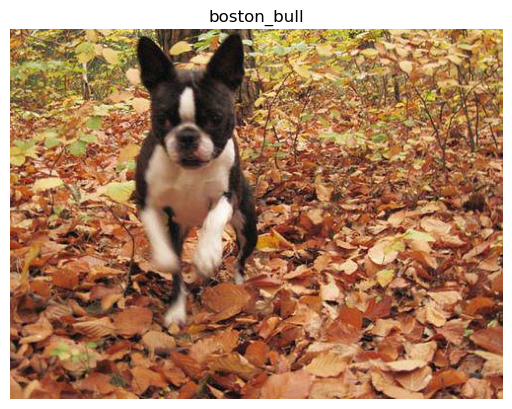

In [18]:
image_item = labels_df.iloc[0]
path_to_image = os.path.join(train_folder, f"{image_item.id}.jpg")
plot_image_from_path(path_to_image, image_item.breed)

# Data Preprocessing <a class="anchor" id="datapreprocessing"></a>

### Data Augmentation <a class="anchor" id="dataaugmentation"></a>

In [19]:
# Data Preprocessing
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"), 
    layers.RandomRotation(0.1),
], name='data_augmentation')

### Labels encoding <a class="anchor" id="labelsencoding"></a>

Encode breeds with a value between 0 and 119 using sklearn.preprocessing.LabelEncoder and then convert these values to one-hot encoding.

In [20]:
labels_df['label'] = LabelEncoder().fit_transform(labels_df.breed)
labels_df.head()

id             breed  label
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull     19
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo     37
2  001cdf01b096e06d78e9e5112d419397          pekinese     85
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick     15
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever     49

In [21]:
labels_list = labels_df['label'].to_numpy().tolist()

In [22]:
# Load your labels dataframe
labels_df['label'] = LabelEncoder().fit_transform(labels_df.breed)
labels_list = labels_df['label'].to_numpy().tolist()
y_full_oh = tf.keras.utils.to_categorical(labels_list, num_classes=120, dtype='float32')
y_full_oh[0:1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Create an additional dictionary for identifying breed labels from numeric values.

In [23]:
labels_breeds_df = labels_df[['label','breed']].copy()
labels_breeds_df.drop_duplicates(inplace=True)
labels_breeds_df.set_index('label',drop=True,inplace=True)
index_to_breed = labels_breeds_df.to_dict()['breed']
list(islice(index_to_breed.items(), 10))

[(19, 'boston_bull'),
 (37, 'dingo'),
 (85, 'pekinese'),
 (15, 'bluetick'),
 (49, 'golden_retriever'),
 (10, 'bedlington_terrier'),
 (18, 'borzoi'),
 (7, 'basenji'),
 (97, 'scottish_deerhound'),
 (99, 'shetland_sheepdog')]

Complete list of all breeds in the dataset.

In [24]:
dog_breeds = sorted(list(index_to_breed.values()))
dog_breeds[:10]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle']

In [25]:
len(dog_breeds)

120

### Create Dataset <a class="anchor" id="createdataset"></a>

Create functions for creating tf.data.Dataset. These functions will be used below in the Model Training section to create datasets with different parameters. To create datasets, I use image_dataset_from_directory function. I also tried from_tensor_slices function with additional image loading and preprocessing functions (including resize_with_pad and CenterCrop), but without better results.

In [26]:
# Create Dataset
def prepare_ds(ds, prep_input_fx, cache_ds=False, shuffle=False, batch_size=32, prefetch=True):
    ds_has_y = isinstance(ds.element_spec, tuple)
    if ds_has_y:
        ds = ds.map(lambda x, y: (prep_input_fx(x), y))
    else:
        ds = ds.map(lambda x: prep_input_fx(x))
    if cache_ds:
        ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(128)
    ds = ds.batch(batch_size)
    if prefetch:
        ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

def create_raw_ds(train_folder, labels_list, split_size=0.1, image_size=(224,224)):
    train_ds_raw, val_ds_raw = tf.keras.utils.image_dataset_from_directory(
        train_folder,
        labels=labels_list,
        label_mode='categorical',
        validation_split=0.1,
        shuffle=False,
        subset="both",
        image_size=image_size,
        batch_size=None,
        crop_to_aspect_ratio=False
    )
    return train_ds_raw, val_ds_raw

#### Data Visualization

Review and visualize images in the created dataset.

In [27]:
train_ds_raw, val_ds_raw = create_raw_ds(train_folder, labels_list, image_size=IMAGE_SIZE)
test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_folder,
    labels=None,
    shuffle=False,
    image_size=IMAGE_SIZE,
    batch_size=None,
    crop_to_aspect_ratio=False
)

train_ds = train_ds_raw.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds_raw.batch(BATCH_SIZE)
test_ds = test_ds_raw.batch(BATCH_SIZE)

Found 10222 files belonging to 120 classes.
Using 9200 files for training.
Using 1022 files for validation.
Found 10357 files belonging to 1 classes.


In [28]:
def plot_ds_images(ds):
    plt.figure(figsize=(10, 10))
    for images, labels in ds.take(1):
        lbl=labels.numpy()
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(index_to_breed[lbl[i].argmax()])
            plt.axis("off")

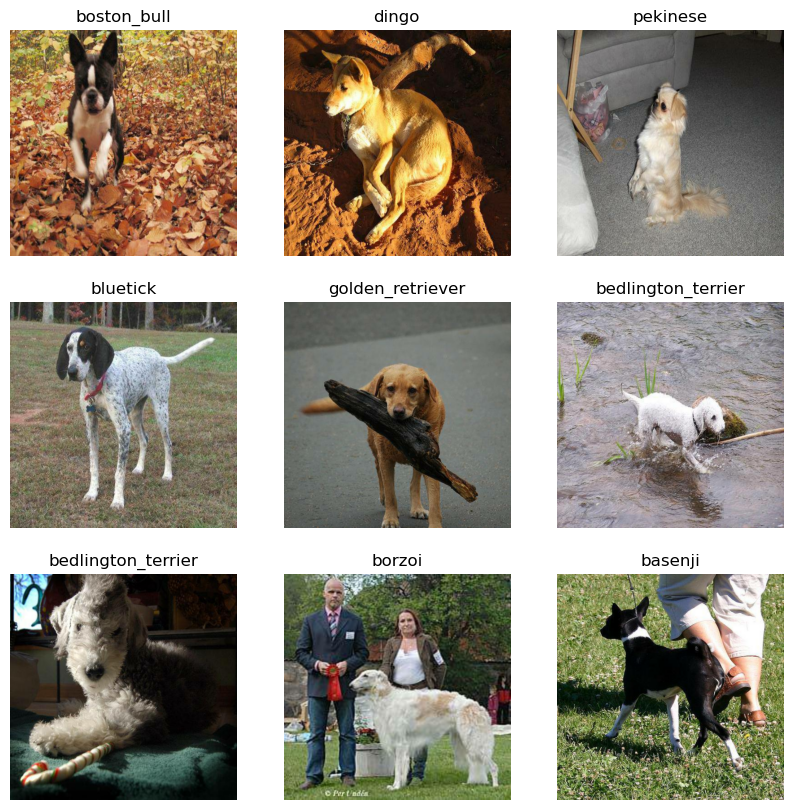

In [29]:
plot_ds_images(train_ds)

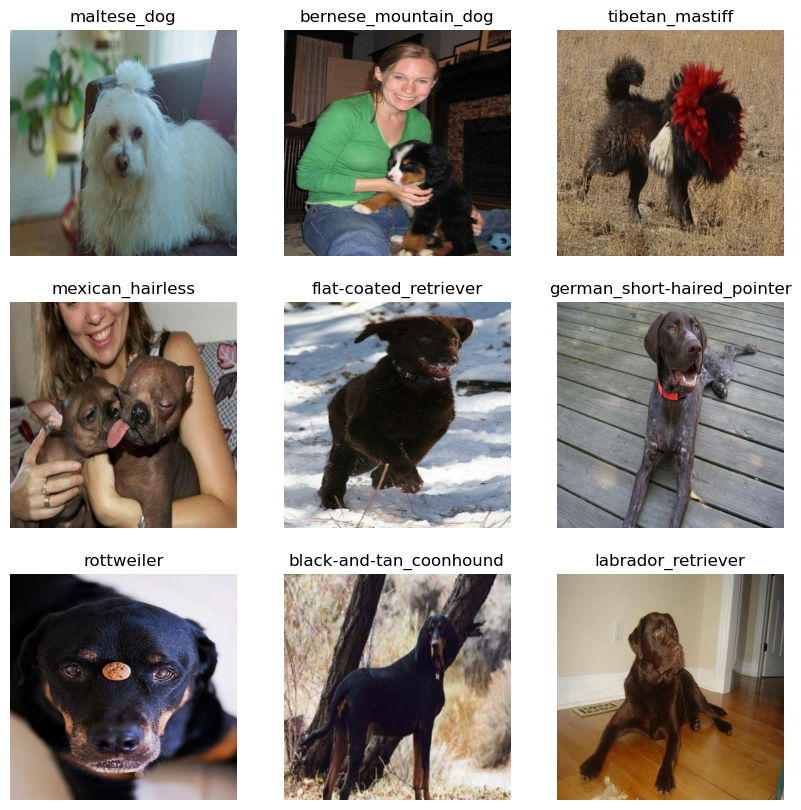

In [30]:
plot_ds_images(val_ds)

Visualize the attention map from the Vision Transformer model.

In [31]:
def plot_attention_map(original_image, attention_image):
    fig, (ax1, ax2) = plt.subplots(ncols = 2)
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    _ = ax1.imshow(original_image)
    _ = ax2.imshow(attention_image)

In [32]:
vit_model_test = vit.vit_b32(
    image_size = IMAGE_SIZE,
    activation = 'softmax',
    pretrained = True,
    include_top = True,
    pretrained_top = False,
    classes = 120
)

1/1 [==============================] - 4s 4s/step


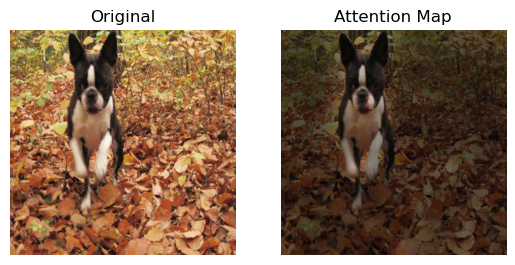

In [33]:
for image, _ in train_ds_raw.take(1):
    image_example = image.numpy().astype('uint8')
    break
attention_map = visualize.attention_map(model = vit_model_test, image = image_example)
plot_attention_map(image_example, attention_map)

In [34]:
del vit_model_test
gc.collect()

19993

# Model Training and Evaluation <a class="anchor" id="trainandevaluate"></a>

In [35]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

checkpoint_cb = ModelCheckpoint(
    'best_model.h5',
    save_best_only=True
)

## Search best models <a class="anchor" id="searchbestmodels"></a>

In [36]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [37]:
def get_keras_model(app_class, shape, base_locked=True, learning_rate=0.001):
    base_model = app_class(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
    )
    inputs = keras.Input(shape=shape)
    aug_inputs = data_augmentation(inputs)
    x = base_model(aug_inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.7)(x)
    outputs = layers.Dense(120, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    base_model.trainable = not base_locked
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=categorical_crossentropy, 
                  optimizer=optimizer,
                  metrics=['categorical_accuracy', 
                           tf.keras.metrics.Precision(name='precision'), 
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.SensitivityAtSpecificity(0.5, name='sensitivity'),
                           tf.keras.metrics.SpecificityAtSensitivity(0.5, name='specificity'),
                           F1Score()
                          ]
                 )
    return model

In [38]:
def get_vit_model(app_class, shape, base_locked=True, learning_rate=0.001):
    base_model = app_class(
        image_size=shape[:2],
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=120
    )
    inputs = keras.Input(shape=shape)
    aug_inputs = data_augmentation(inputs)
    x = base_model(aug_inputs)
    x = layers.Dropout(0.7)(x)
    outputs = layers.Dense(120, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    base_model.trainable = not base_locked
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=categorical_crossentropy, 
                  optimizer=optimizer,
                  metrics=['categorical_accuracy', 
                           tf.keras.metrics.Precision(name='precision'), 
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.SensitivityAtSpecificity(0.5, name='sensitivity'),
                           tf.keras.metrics.SpecificityAtSensitivity(0.5, name='specificity'),
                           F1Score()
                          ]
                 )
    return model

In [39]:
models_search = {
    'vit_l32': [vit.vit_l32, vit.preprocess_inputs],
    'EfficientNetB4': [EfficientNetB4, keras.applications.efficientnet.preprocess_input],
    'InceptionResNetV2': [InceptionResNetV2, keras.applications.inception_resnet_v2.preprocess_input],
    'MobileNetV2': [MobileNetV2, keras.applications.mobilenet.preprocess_input],
    'Xception': [Xception, keras.applications.xception.preprocess_input],
    'DenseNet201': [DenseNet201, keras.applications.densenet.preprocess_input],
}

In [40]:
history_dict = {}
for model_name, (model_class, preprocess_input) in models_search.items():
    print(f"Training {model_name}...")
    if model_name.startswith('vit'):
        model = get_vit_model(model_class, IMAGE_SIZE + (3,))
    else:
        model = get_keras_model(model_class, IMAGE_SIZE + (3,))
    
    history = model.fit(
        prepare_ds(train_ds_raw, preprocess_input, shuffle=True),
        validation_data=prepare_ds(val_ds_raw, preprocess_input),
        epochs=10,
        callbacks=[early_stopping, reduce_lr_on_plateau, checkpoint_cb]
    )
    # Convert history to native Python types
    history_dict[model_name] = {k: [float(val) for val in v] for k, v in history.history.items()}
    tf.keras.backend.clear_session()  # Clear session to free memory
    gc.collect()  # Collect garbage to free memory

Training vit_l32...
1226658854/1226658854 [==============================] - 10s 0us/step
Epoch 1/10
288/288 [==============================] - 309s 979ms/step - loss: 1.7076 - categorical_accuracy: 0.6426 - precision: 0.8934 - recall: 0.5266 - sensitivity: 0.8998 - specificity: 0.9996 - f1_score: 0.6627 - val_loss: 0.1304 - val_categorical_accuracy: 0.9628 - val_precision: 0.9769 - val_recall: 0.9521 - val_sensitivity: 0.9971 - val_specificity: 1.0000 - val_f1_score: 0.9643 - lr: 0.0010
Epoch 2/10
288/288 [==============================] - 274s 951ms/step - loss: 0.4027 - categorical_accuracy: 0.8921 - precision: 0.9250 - recall: 0.8643 - sensitivity: 0.9867 - specificity: 0.9999 - f1_score: 0.8936 - val_loss: 0.1114 - val_categorical_accuracy: 0.9677 - val_precision: 0.9752 - val_recall: 0.9628 - val_sensitivity: 0.9961 - val_specificity: 1.0000 - val_f1_score: 0.9690 - lr: 0.0010
Epoch 3/10
288/288 [==============================] - 274s 952ms/step - loss: 0.3304 - categorical_accur

2024-08-06 17:34:57.920616: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 142s 445ms/step - loss: 2.1553 - categorical_accuracy: 0.6568 - precision: 0.9730 - recall: 0.1721 - sensitivity: 0.9866 - specificity: 0.9989 - f1_score: 0.2924 - val_loss: 0.5620 - val_categorical_accuracy: 0.9325 - val_precision: 0.9796 - val_recall: 0.7524 - val_sensitivity: 1.0000 - val_specificity: 1.0000 - val_f1_score: 0.8511 - lr: 0.0010
Epoch 2/10
288/288 [==============================] - 122s 423ms/step - loss: 0.5356 - categorical_accuracy: 0.8941 - precision: 0.9571 - recall: 0.7572 - sensitivity: 0.9992 - specificity: 0.9999 - f1_score: 0.8455 - val_loss: 0.2736 - val_categorical_accuracy: 0.9393 - val_precision: 0.9624 - val_recall: 0.9012 - val_sensitivity: 0.9990 - val_specificity: 1.0000 - val_f1_score: 0.9308 - lr: 0.0010
Epoch 3/10
288/288 [==============================] - 123s 425ms/step - loss: 0.3650 - categorical_accuracy: 0.9118 - precision: 0.9509 - recall: 0.8552 - sensitivity: 0.9988 - specificity: 1.0000 - f1_sco

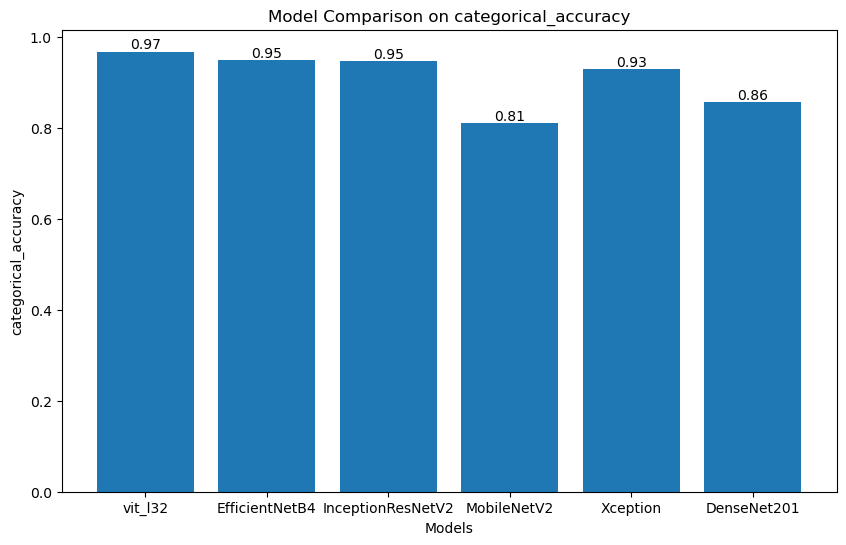

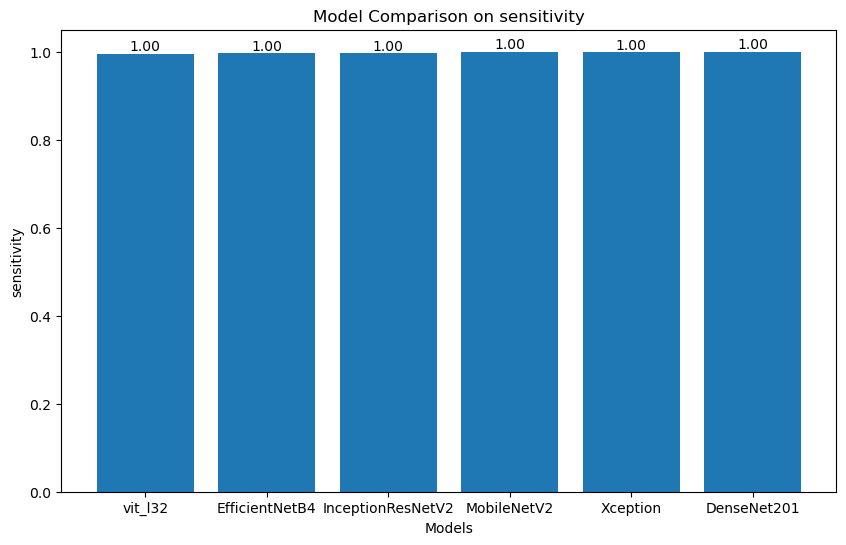

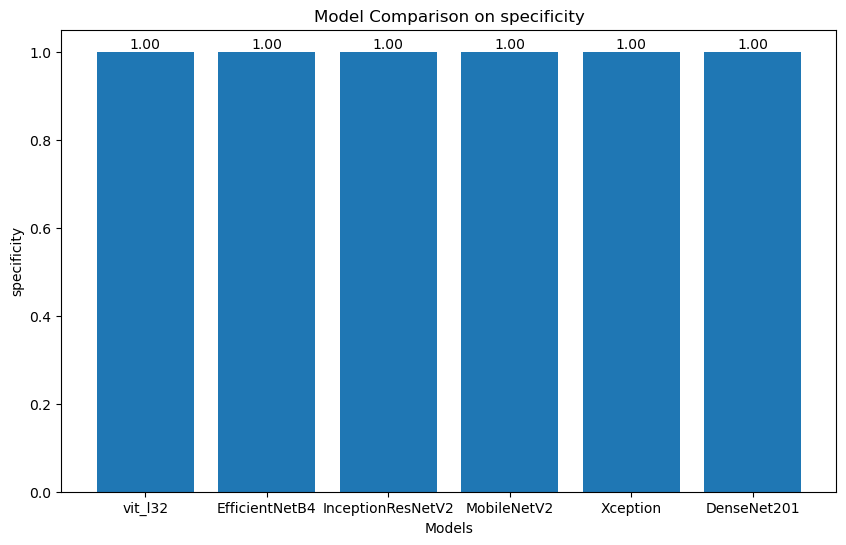

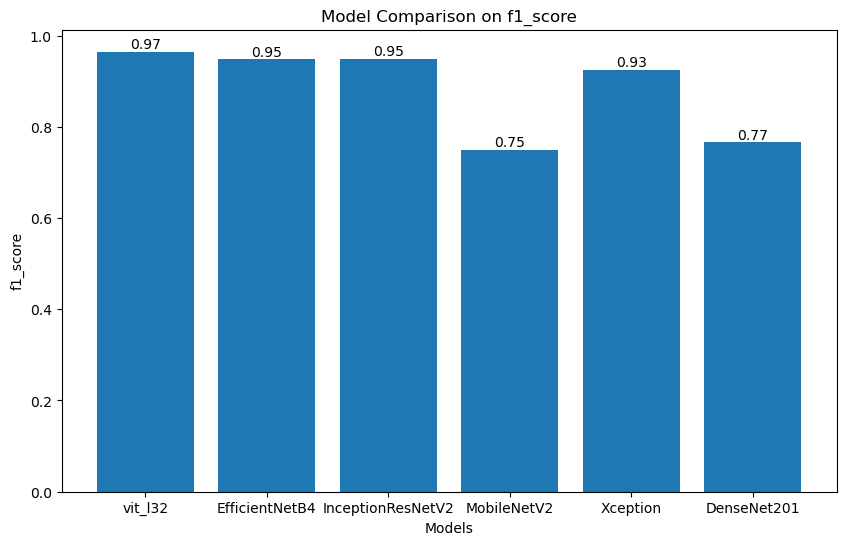

In [41]:
metrics = ['categorical_accuracy', 'precision', 'recall', 'sensitivity', 'specificity', 'f1_score']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    metric_values = [history_dict[model_name][f'val_{metric}'][-1] for model_name in models_search.keys()]
    plt.bar(models_search.keys(), metric_values)
    
    # Add data labels
    for index, value in enumerate(metric_values):
        plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

    plt.title(f'Model Comparison on {metric}')
    plt.xlabel('Models')
    plt.ylabel(metric)
    plt.show()

## Stacking classifier <a class="anchor" id="stackingclassifier"></a>

Select some best models for further stacking and training.

I use here only transfer learning without fine-tuning (I also tried it, but without better results). Therefore I use here technique for feature extraction from base stacking model (without top classifier layer) and pass them for training top MLP model (again not only NN but other models like logistic regression can be used). This approach also reduces the training time.

In [42]:
# Stacking classifier
def build_feat_model(models_names, shape, aug_layer=None):
    all_outputs = []
    inputs = keras.Input(shape=shape)
    if aug_layer != None:
        aug_inputs = aug_layer(inputs)
    else:
        aug_inputs = inputs
    for model_name in models_names:
        model_class, preprocess_input = models_search[model_name]
        if model_name.startswith('vit'):
            base_model = model_class(
                image_size=shape[:2],
                activation='softmax',
                pretrained=True,
                include_top=False,
                pretrained_top=False,
                classes=120
            )
            x = preprocess_input(aug_inputs)
            outputs = base_model(x)
        else:
            base_model = model_class(
                include_top=False,
                weights='imagenet',
                input_shape=shape,
            )
            x = preprocess_input(aug_inputs)
            x = base_model(x)
            outputs = layers.GlobalAveragePooling2D()(x)
        all_outputs.append(outputs)
    concat_outputs = layers.Concatenate()(all_outputs)
    model = Model(inputs, concat_outputs)
    return model

In [43]:
stack_models = ['vit_l32', 'EfficientNetB4', 'InceptionResNetV2']
model_features = build_feat_model(stack_models, IMAGE_SIZE + (3,), data_augmentation)
model_features.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 448, 448, 3)  0          ['input_1[0][0]']                
                                                                                                  
 tf.math.truediv_1 (TFOpLambda)  (None, 448, 448, 3)  0          ['data_augmentation[6][0]']      
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 448, 448, 3)  0           ['data_augmentation[6][0]']  

In [44]:
# Extract features
def get_features_from_model(model, ds, count=1):
    features = []
    ds_has_y = isinstance(ds.element_spec, tuple)
    if ds_has_y:
        labels = []
        y = np.concatenate([y for x, y in ds], axis=0)
    for i in range(count):
        predictions = model.predict(ds)
        features.append(predictions)
        if ds_has_y:
            labels.append(y)
    if ds_has_y:
        return np.concatenate(features), np.concatenate(labels)
    else:
        return np.concatenate(features)

features_train, y_train = get_features_from_model(model_features, train_ds, count=2)
features_val, y_val = get_features_from_model(model_features, val_ds)

32/32 [==============================] - 45s 1s/step


With param count we can multiply dataset and each count will get slightly different features because of using data augmentation layer.

After extracting features from the base model, create Dense top model and train it on those features. I use MCDropout here instead of regular dropout. It allows to slightly increase the performance on the test dataset.

In [47]:
# Train top model with early stopping to prevent overfitting
dnn_model = keras.models.Sequential([
    Input(features_train.shape[1:]),
    layers.Dropout(0.7),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(120, activation='softmax')
])

dnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy', 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.SensitivityAtSpecificity(0.5, name='sensitivity'),
             tf.keras.metrics.SpecificityAtSensitivity(0.5, name='specificity'),
             F1Score()
            ]
)

history_dnn = dnn_model.fit(
    features_train, 
    y_train,
    validation_data=(features_val, y_val),
    batch_size=128,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau, checkpoint_cb]
)

Epoch 1/50
144/144 [==============================] - 5s 11ms/step - loss: 7.2274 - categorical_accuracy: 0.5795 - precision: 0.9248 - recall: 0.3601 - sensitivity: 0.9123 - specificity: 0.9989 - f1_score: 0.5184 - val_loss: 3.4158 - val_categorical_accuracy: 0.9589 - val_precision: 0.9753 - val_recall: 0.9286 - val_sensitivity: 1.0000 - val_specificity: 1.0000 - val_f1_score: 0.9514 - lr: 0.0010
Epoch 2/50
144/144 [==============================] - 1s 7ms/step - loss: 2.6376 - categorical_accuracy: 0.9037 - precision: 0.9473 - recall: 0.8251 - sensitivity: 0.9936 - specificity: 0.9999 - f1_score: 0.8820 - val_loss: 1.6946 - val_categorical_accuracy: 0.9599 - val_precision: 0.9785 - val_recall: 0.9354 - val_sensitivity: 0.9980 - val_specificity: 1.0000 - val_f1_score: 0.9565 - lr: 0.0010
Epoch 3/50
144/144 [==============================] - 1s 7ms/step - loss: 1.5702 - categorical_accuracy: 0.9182 - precision: 0.9469 - recall: 0.8767 - sensitivity: 0.9939 - specificity: 1.0000 - f1_sco

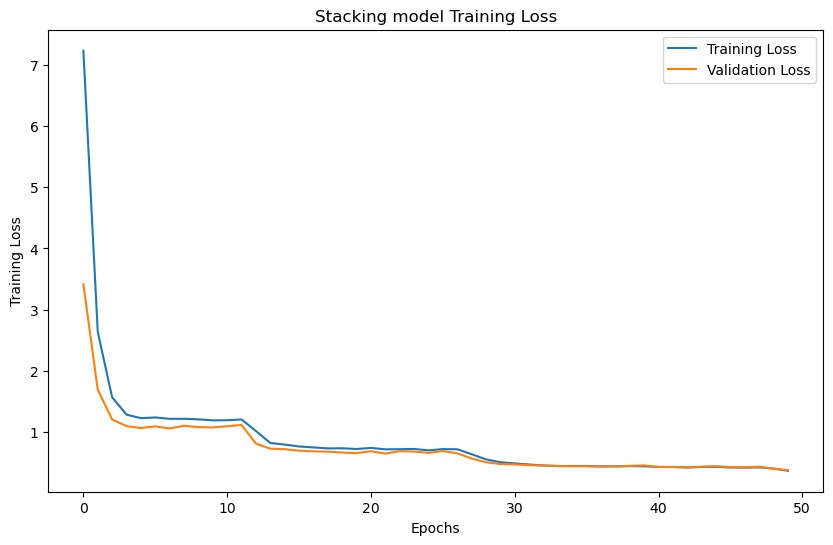

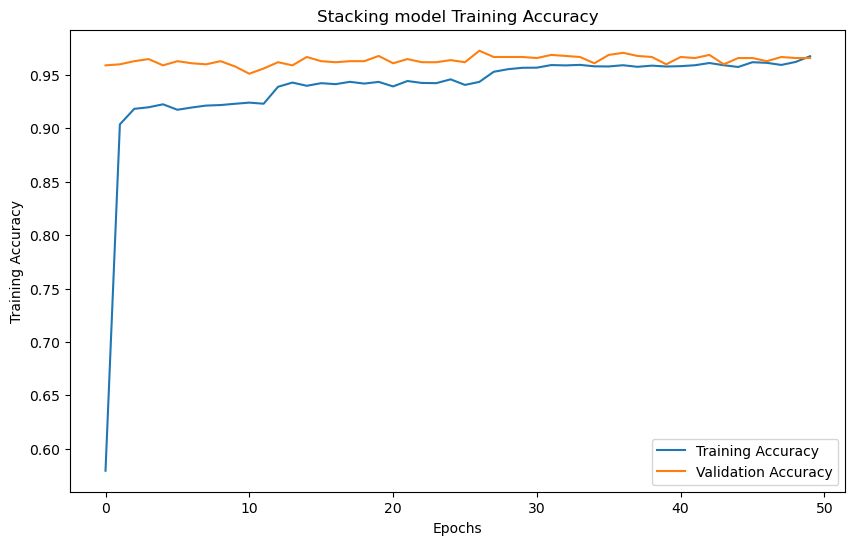

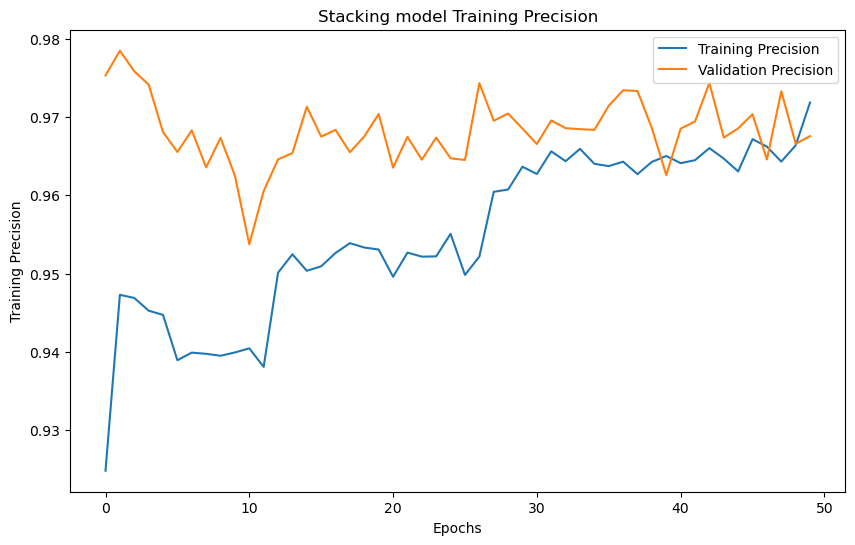

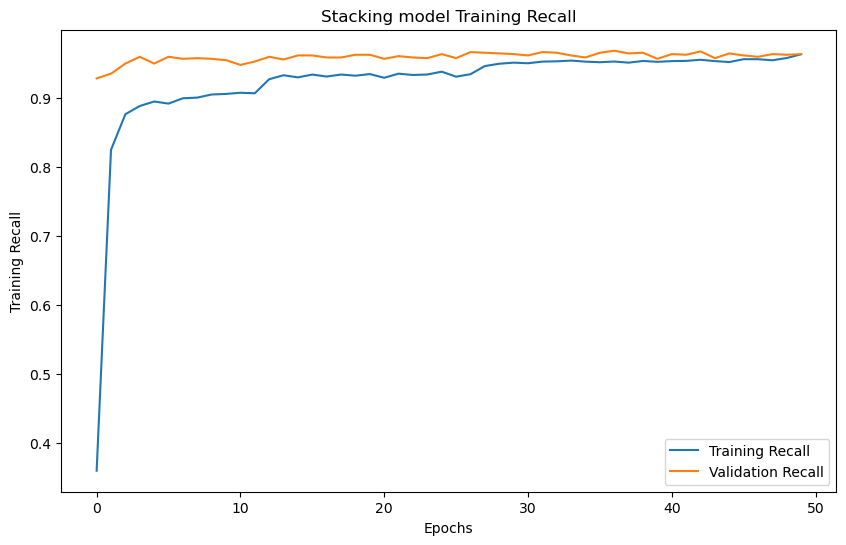

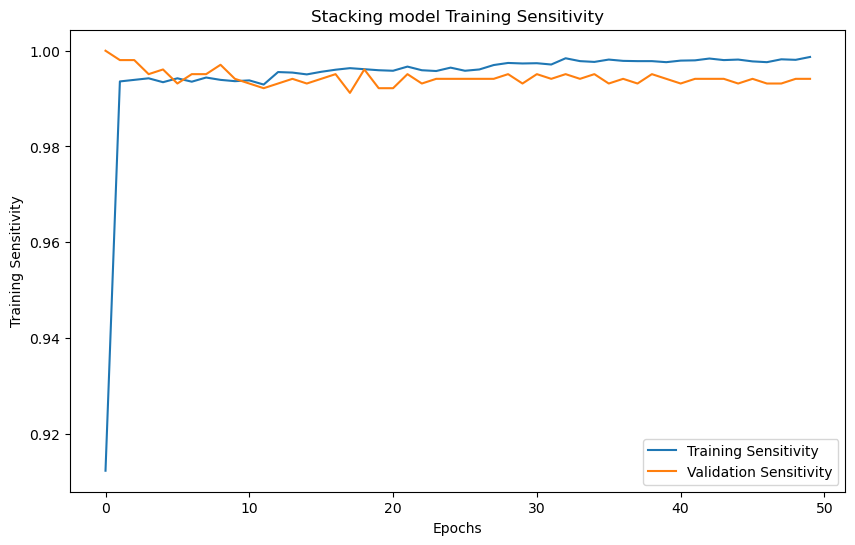

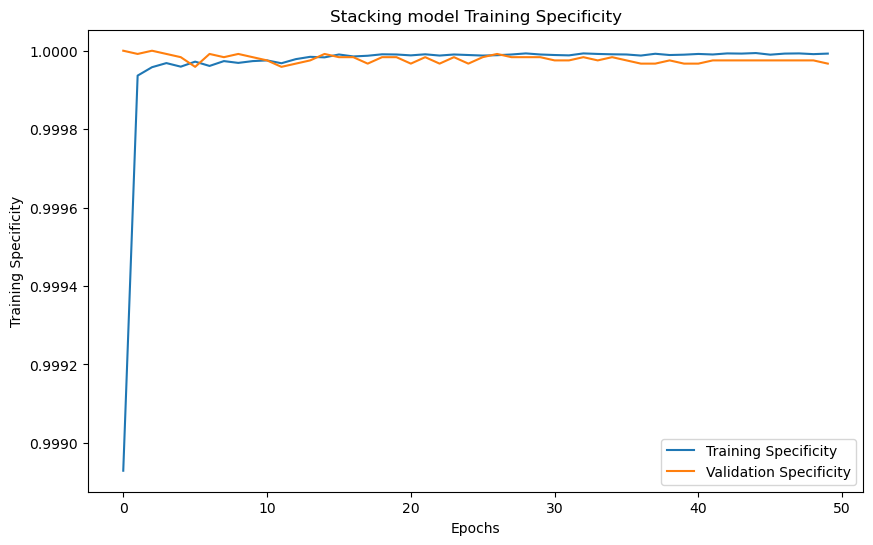

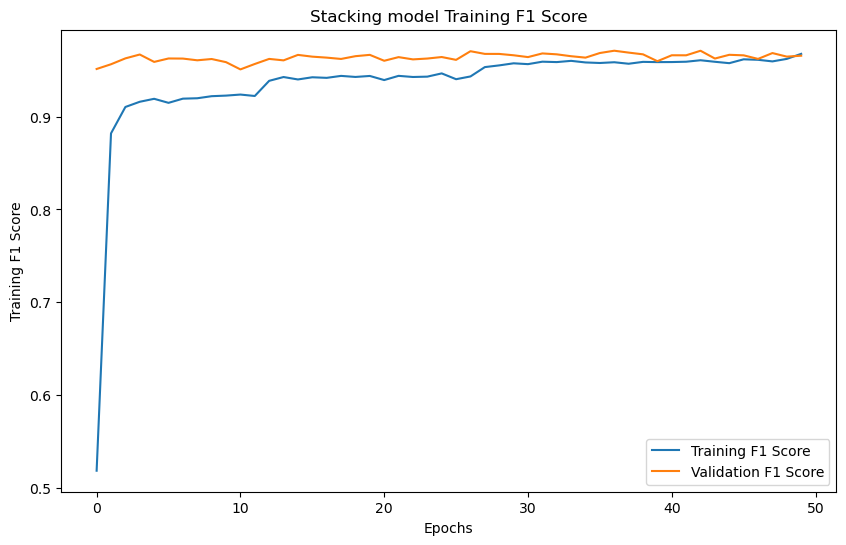

In [48]:
# Dictionary to map metric keys to their display names
metric_titles = {
    'loss': 'Training Loss',
    'categorical_accuracy': 'Training Accuracy',
    'precision': 'Training Precision',
    'recall': 'Training Recall',
    'sensitivity': 'Training Sensitivity',
    'specificity': 'Training Specificity',
    'f1_score': 'Training F1 Score',
    'val_loss': 'Validation Loss',
    'val_categorical_accuracy': 'Validation Accuracy',
    'val_precision': 'Validation Precision',
    'val_recall': 'Validation Recall',
    'val_sensitivity': 'Validation Sensitivity',
    'val_specificity': 'Validation Specificity',
    'val_f1_score': 'Validation F1 Score'
}

metrics = ['loss', 'categorical_accuracy', 'precision', 'recall', 'sensitivity', 'specificity', 'f1_score']

for metric in metrics:
    if metric in history_dnn.history:
        plt.figure(figsize=(10, 6))
        plt.plot(history_dnn.history[metric], label=metric_titles[metric])
        val_metric = f'val_{metric}'
        if val_metric in history_dnn.history:
            plt.plot(history_dnn.history[val_metric], label=metric_titles[val_metric])
        plt.title(f'Stacking model {metric_titles[metric]}')
        plt.xlabel('Epochs')
        plt.ylabel(metric_titles[metric])
        plt.legend()
        plt.show()
    else:
        print(f"Metric '{metric}' not found in history_dnn.history")


# Conclusion <a class="anchor" id="conclusion"></a>

Comparison of CNN and ViT models showed that the latter (large versions with patch equal to 32) get better performance (I also tested them on full dataset with different image sizes). Staking the models allowed to increase the individual scores. The achieved loss is not very low (compared to the top leaderboard positions with losses of 0 and little more), but good enough.

## Testing with Custom Inputs

In [151]:
class_labels = sorted(labels_df['breed'].unique())

# Function to predict from image path
def predict_from_image_path(img_path):
    # Load and preprocess the image
    img = load_img(img_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Extract features using the feature model
    features = model_features.predict(img_array)
    
    # Predict using the top DNN model
    predictions = dnn_model.predict(features)
    
    # Get the predicted class index
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    
    # Get the predicted class label
    predicted_class_label = class_labels[predicted_class_index]
    
    # Get the probability of the prediction
    probability = np.max(predictions, axis=1)[0] * 100
    
    print(f"Predicted label: {predicted_class_label}")
    print(f"Probability of prediction: {probability:.2f} %")
    
    return predicted_class_label, probability

# Example usage
img_path = '/kaggle/input/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg'
predicted_class_label, probability = predict_from_image_path(img_path)

1/1 [==============================] - 0s 19ms/step
Predicted label: golden_retriever
Probability of prediction: 99.22 %


# END